In [1]:
!pip install pymystem3
!pip install stanza

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.3/691.3 kB 2.8 MB/s eta 0:00:00a 0:00:01


In [2]:
import re
import os
import requests
from string import punctuation
from collections import defaultdict, Counter
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd

import stanza
stanza.download('ru')
nlp = stanza.Pipeline('ru', processors='tokenize,lemma')

from pymystem3 import Mystem 
mystem = Mystem()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import classification_report, roc_auc_score
      
import torch
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


/kaggle/input/nlp-project/train_split_aspects.txt
/kaggle/input/nlp-project/train_split_cats.txt
/kaggle/input/nlp-project/dev_cats.txt
/kaggle/input/nlp-project/dev_pred_aspects_old.txt
/kaggle/input/nlp-project/train_split_reviews.txt
/kaggle/input/nlp-project/dev_aspects.txt
/kaggle/input/nlp-project/dev_reviews.txt
/kaggle/input/nlp-project/dev_pred_cats_old.txt


In [3]:
food_page = requests.get('https://fitaudit.ru/food/abc').text

In [4]:
food_items = re.findall(r'<a class="vertical_pseudo" href=.+? title="(.+?)\(.+?\)">', food_page)
food_cats = {tuple(food.lower().strip().split()): 'Food' for food in food_items}
food_sents = {tuple(food.lower().strip().split()): 'positive' for food in food_items}

In [5]:
len(food_cats)

602

## 1. Data Loader

In [25]:
df_asp = pd.read_csv('/kaggle/input/nlp-project/train_split_aspects.txt', sep='\t', 
                     header=None, names=['review_id', 'category', 'token', 'start', 'end', 'sentiment'])
df_asp.head()

,review_id,category,token,start,end,sentiment
0,30808,Whole,ресторане,16,25,neutral
1,30808,Interior,первом этаже,43,55,neutral
2,30808,Whole,руководству ресторана,124,145,positive
3,30808,Service,обслуживающему персоналу,147,171,positive
4,30808,Service,сотрудникам,189,200,positive


In [26]:
df_cats = pd.read_csv('/kaggle/input/nlp-project/train_split_cats.txt', sep='\t', 
                      header=None, names=['review_id', 'category', 'sentiment'])
df_cats.head()

,review_id,category,sentiment
0,30808,Food,positive
1,30808,Interior,positive
2,30808,Price,positive
3,30808,Whole,positive
4,30808,Service,positive


In [27]:
df_reviews = pd.read_csv('/kaggle/input/nlp-project/train_split_reviews.txt', sep='\t', 
                      header=None, names=['review_id', 'text'])
df_reviews.head()

,review_id,text
0,25709,"Были 1 февраля. Я второй раз, подруга - первый..."
1,10099,Были в Дитае на прошлой неделе с подругой. Заш...
2,1105,Один из моих любимых ресторанов. С самого откр...
3,3647,Остались очень довольны. Хотим поблагодарить ш...
4,37070,приехали к друзьям в Питер из Москвы на Новый ...


In [28]:
df_asp_test = pd.read_csv('/kaggle/input/nlp-project/dev_aspects.txt', sep='\t', 
                     header=None, names=['review_id', 'category', 'token', 'start', 'end', 'sentiment'])
df_asp_test.head()

,review_id,category,token,start,end,sentiment
0,3976,Whole,ресторане,71,80,neutral
1,3976,Whole,ресторанах,198,208,neutral
2,3976,Whole,ресторане,256,265,neutral
3,3976,Service,Столик бронировали,267,285,neutral
4,3976,Service,администратор,322,335,positive


In [29]:
df_reviews_test = pd.read_csv('/kaggle/input/nlp-project/dev_reviews.txt', sep='\t', 
                     header=None, names=['review_id', 'text'])
df_reviews_test.head()

,review_id,text
0,13823,"Зашли в""аппетит"" случайно.Не смотря на то,что ..."
1,1427,Здравствуйте!Посетили ваше заведение вчера пер...
2,16714,"Были в пятницу (19.03.10), заказывали столик д..."
3,797,"Были в ресторане 2 раза. Один раз днем, все по..."
4,34710,Удивляюсь отзывам про хорошее обслуживание. Бы...


## 2. EDA

In [30]:
print('Всего ревью:', len(df_reviews))
print('Всего оценок:', len(df_asp))

Всего ревью: 213
Всего оценок: 3573


Больше всего комментариев в ревью было сделано относительно категории Food.

In [31]:
df_asp['category'].value_counts()#.plot.barh()

Food        1439
Service      909
Whole        611
Interior     514
Price        100
Name: category, dtype: int64

Сентименты в основном положительные.

<AxesSubplot:>

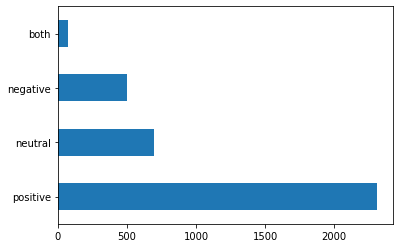

In [32]:
df_asp['sentiment'].value_counts().plot.barh()

In [33]:
categories = list(df_asp['category'].unique())
categories

['Whole', 'Interior', 'Service', 'Food', 'Price']

# 4.1 Решение на основе частотного словаря

Строим частотный словарь "токенизированное упоминание + категория"

In [34]:
def get_mention_category(data, col):
    lemma_cat_count = data.value_counts(subset=['token', col])
    lemma_cat_dict = defaultdict(dict)
    for key, value in lemma_cat_count.items():
        lemma_cat_dict[key[0]][key[1]] = value
    return {tuple(k.lower().split()): Counter(v).most_common(1)[0][0] for k, v in lemma_cat_dict.items()}

In [35]:
best_mention_category = get_mention_category(df_asp, 'category')
best_mention_sentiment = get_mention_category(df_asp, 'sentiment')
len(best_mention_category)

**Запускаем следующие ячейки в зависимости от того, какой эксперимент мы хотим воспроизвести.**

## Эксперимент 1: Добавление в словарь новых сущностей категории Food

In [35]:
# best_mention_category = {**best_mention_category, **food_cats}
# best_mention_sentiment = {**best_mention_sentiment, **food_sents}

## Эксперимент 2: Лемматизация всех значений

In [ ]:
# best_mention_category_lemm = {}
# for mention, category in list(best_mention_category.items()):
#     tokens = ' '.join(mention)
#     lemma = tuple(mystem.lemmatize(tokens)[:-1])
#     best_mention_category_lemm[lemma] = category
    
# best_mention_sentiment_lemm = {}
# for mention, sentiment in list(best_mention_sentiment.items()):
#     tokens = ' '.join(mention)
#     lemma = tuple(mystem.lemmatize(tokens)[:-1])
#     best_mention_sentiment_lemm[lemma] = sentiment

## Эксперимент 3: SBERT

In [50]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


def tokenize(corpus, tokenizer, device):
    return {
        k: t.to(device) for k, t in 
        tokenizer(
            corpus, padding=True, truncation=True, max_length=256, return_tensors='pt'
        ).items()
    }


def get_corpus_embeddings(corpus, model, tokenizer, device):
    step_size = 256
    max_len = len(corpus)
    n_steps = max_len // step_size + (max_len % step_size > 0)
    
    mention_embeddings = []
    for i in tqdm(range(n_steps)):
        start = i * step_size
        stop = min(max_len, (i + 1) * step_size)

        enc = tokenize(corpus[start:stop], tokenizer, device)
        with torch.no_grad():
            emb = model(**enc)
        semb = mean_pooling(emb, enc['attention_mask'])
        mention_embeddings.append(semb.detach().cpu().numpy().astype(np.float32))
    mention_embeddings = np.concatenate(mention_embeddings)
    # np.save('mention_embeddings', mention_embeddings)
    return mention_embeddings

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("sberbank-ai/sbert_large_nlu_ru").to(device)

In [51]:
gold_sents = [' '.join(mention) for mention, sent in best_mention_sentiment.items()]
gold_sents_embeddings = get_corpus_embeddings(gold_sents, model, tokenizer, device)

new_food = [' '.join(mention) for mention, sent in food_sents.items()]
new_food_embeddings = get_corpus_embeddings(new_food, model, tokenizer, device)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [52]:
X_train = gold_sents_embeddings
y_train = [sent for mention, sent in best_mention_sentiment.items()]
X_test = new_food_embeddings

clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [57]:
food_sents_pred = {tuple(name.split()): sent for name, sent in zip(new_food, pred)}
best_mention_sentiment = {**best_mention_sentiment, **food_sents_pred}

## Предсказание категорий текстов

In [58]:
print('Длины упоминаний аспектов в трейне:', Counter([len(x) for x in best_mention_sentiment.keys()]))

Длины упоминаний аспектов в трейне: Counter({1: 1043, 2: 660, 3: 180, 4: 57, 5: 21, 6: 8, 7: 6, 8: 2})


In [59]:
def label_texts(text, mentions, sentiments, max_len=5):
    tokenized = [word for sent in nlp(text).sentences for word in sent.words]
    text_end = len(tokenized)
    for i, token in enumerate(tokenized):
        for l in reversed(range(max_len)):
            if i + l > text_end:
                continue
            span = tokenized[i:i + l]
            key = tuple([t.lemma for t in span])
            if key in mentions:
                start, end = span[0].start_char, span[-1].end_char
                yield mentions[key], text[start:end], start, end, sentiments[key]
                break

In [60]:
with open('dev_pred_aspects.txt', 'w') as f:
    for text, idx in tqdm(zip(df_reviews_test['text'], df_reviews_test['review_id']), total=len(df_reviews_test)):
            for asp in label_texts(text, best_mention_category, best_mention_sentiment):
                print(idx, *asp, sep="\t", file=f)

  0%|          | 0/71 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7f101f10e560>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/opt/conda/lib/python3.7/site-packages/tqdm/notebook.py", line 286, in close
    if self.total and self.n < self.total:
TypeError: '<' not supported between instances of 'int' and 'range'


##  Упоминания аспектов с предсказанной тональностью

In [61]:
def get_full_sentiment(text, mentions, sentiment, categories, max_len=5):
    asp_counter = defaultdict(Counter)
    for asp in label_texts(text, mentions, sentiment, max_len):
        category, *_, sentiment = asp
        asp_counter[category][sentiment] += 1
    for c in categories:
        if not asp_counter[c]:
            s = 'absence'
        elif len(asp_counter[c]) == 1:
            s = asp_counter[c].most_common(1)[0][0]
        else:
            s = 'both'
        yield c, s

In [62]:
with open('dev_pred_cats.txt', 'w') as f:
    for text, idx in tqdm(zip(df_reviews_test['text'], df_reviews_test['review_id']), total=len(df_reviews_test)):
        for c, s in get_full_sentiment(text, best_mention_category, best_mention_sentiment, categories):
            print(idx, c, s, sep="\t", file=f)

  0%|          | 0/71 [00:00<?, ?it/s]

## Эксперимент 2. Решение с помощью лемматизации

Следующие ячейки запускаются только при выполнении 2-го эксперимента, связанного с лемматизацией. 

**dev_pred_cats.txt**

```
13823 Whole both
13823 Interior absence
13823 Service both
13823 Food positive
```

**dev_pred_aspects.txt**

```
13823 Whole аппетит 8 15 neutral
13823 Service менеджер 147 155 positive
13823 Service девушка 179 186 positive
```

In [43]:
def extract_aspects(text_id, lemma2token, best_mention_category, best_mention_sentiment):
    pred_aspects = []
    for lemma, token_coord in lemma2token.items():
        lemma = tuple(lemma.split())
        tokens = [list(t.keys())[0] for t in token_coord]
        start_coords = [list(t.values())[0][0] for t in token_coord]
        end_coords = [list(t.values())[0][1] for t in token_coord]
        if lemma in best_mention_category:
            category = best_mention_category[lemma]
            sentiment = best_mention_sentiment[lemma] 
            for token, start, end in zip(tokens, start_coords, end_coords):
                pred = [text_id, category, token, start, end, sentiment]
                pred_aspects.append(pred)
    return pred_aspects


def get_pred_aspects(text_id, text, best_mention_category, best_mention_sentiment):
    tokenized = [word for sent in nlp(text).sentences for word in sent.words]
    lemma2token = {}
    
    # Составляю словарь {лемма1: [{токен1: (начало, конец), {токен2: (начало, конец)}]}
    for token_info in tokenized:
        lemma = token_info.lemma

        if lemma not in punctuation:
            id_ = token_info.id
            token = token_info.text.lower()
            start = token_info.start_char
            end = token_info.end_char
            token_coord = {token: (start, end)}

            if lemma not in lemma2token:
                lemma2token[lemma] = [token_coord]
            else:
                lemma2token[lemma].append(token_coord)

    pred_aspects = extract_aspects(text_id, lemma2token, best_mention_category, best_mention_sentiment)
    return pred_aspects

In [44]:
aspect_predictions = []

for text_id, text in tqdm(zip(df_reviews_test['review_id'], df_reviews_test['text']), total=len(df_reviews_test)):
    pred = get_pred_aspects(text_id, text, best_mention_category, best_mention_sentiment)
    aspect_predictions.extend(pred)

  0%|          | 0/71 [00:00<?, ?it/s]

In [45]:
with open('dev_pred_aspects.txt', 'w') as f:
    for asp in tqdm(aspect_predictions):
        print(*asp, sep="\t", file=f)

  0%|          | 0/1408 [00:00<?, ?it/s]

In [46]:
def get_full_sentiment2(text_id, text, mentions, sentiment, categories, max_len=5):
    asp_counter = defaultdict(Counter)
    for asp in get_pred_aspects(text_id, text, mentions, sentiment):
        category = asp[1]
        sentiment = asp[5]
        asp_counter[category][sentiment] += 1
    for c in categories:
        if not asp_counter[c]:
            s = 'absence'
        elif len(asp_counter[c]) == 1:
            s = asp_counter[c].most_common(1)[0][0]
        else:
            s = 'both'
        yield c, s

In [47]:
with open('dev_pred_cats.txt', 'w') as f:
    for text, idx in tqdm(zip(df_reviews_test['text'], df_reviews_test['review_id']), total=len(df_reviews_test)):
        for c, s in get_full_sentiment2(idx, text, best_mention_category, best_mention_sentiment, categories):
            print(idx, c, s, sep="\t", file=f)

  0%|          | 0/71 [00:00<?, ?it/s]

# Evaluation
## Оценка 1: accuracy по выделению упоминаний с категориями

In [63]:
gold_test_path = "/kaggle/input/nlp-project/dev_aspects.txt"
pred_test_path = "/kaggle/working/dev_pred_aspects.txt"

In [64]:
def get_gold_aspect_cats(gold_test_path):
    gold_aspect_cats = {}
    with open(gold_test_path) as fg:
        for line in fg:
            line = line.rstrip('\r\n').split('\t')
            if line[0] not in gold_aspect_cats:
                gold_aspect_cats[line[0]] = {"starts":[], "ends":[], "cats":[], "sents":[]}
            gold_aspect_cats[line[0]]["starts"].append(int(line[3]))
            gold_aspect_cats[line[0]]["ends"].append(int(line[4]))
            gold_aspect_cats[line[0]]["cats"].append(line[1])
            gold_aspect_cats[line[0]]["sents"].append(line[5])
    return gold_aspect_cats

In [65]:
def evaluation(gold_aspect_cats, pred_test_path):
    full_match, partial_match, full_cat_match, partial_cat_match = 0, 0, 0, 0
    total = 0
    errors = []
    fully_matched_pairs = []
    partially_matched_pairs = []
    with open(pred_test_path) as fp:
        for line in fp:    
            total += 1
            line = line.rstrip('\r\n').split('\t')
            text_id = line[0]
            start, end = int(line[3]), int(line[4])
            category = line[1]
            
            doc_gold_aspect_cats = gold_aspect_cats[text_id]
            
            if start in doc_gold_aspect_cats["starts"]:
                i = doc_gold_aspect_cats["starts"].index(start)
                if doc_gold_aspect_cats["ends"][i] == end:
                    full_match += 1
                    if doc_gold_aspect_cats["cats"][i] == category:
                        full_cat_match += 1
                    else:
                        partial_cat_match += 1
                        
                    fully_matched_pairs.append(
                        (
                            [
                                doc_gold_aspect_cats["starts"][i], 
                                doc_gold_aspect_cats["ends"][i], 
                                doc_gold_aspect_cats["cats"][i],
                                doc_gold_aspect_cats["sents"][i]
                            ],
                            line
                        )
                    )
                    continue
            else:
                errors.append(line)
            
            for s_pos in doc_gold_aspect_cats["starts"]:
                if start <= s_pos:
                    i = doc_gold_aspect_cats["starts"].index(s_pos)
                    if doc_gold_aspect_cats["ends"][i] == end:
                        partial_match += 1
                        partially_matched_pairs.append(
                            (
                                [
                                    doc_gold_aspect_cats["starts"][i], 
                                    doc_gold_aspect_cats["ends"][i], 
                                    doc_gold_aspect_cats["cats"][i],
                                    doc_gold_aspect_cats["sents"][i]
                                ],
                                line
                            )
                        )
                        if doc_gold_aspect_cats["cats"][i] == category:
                            partial_cat_match += 1
                        continue
                    matched = False
                    for e_pos in doc_gold_aspect_cats["ends"][i:]:
                        if s_pos <= end <= e_pos:
                            partial_match += 1
                            partially_matched_pairs.append(
                                (
                                    [
                                        doc_gold_aspect_cats["starts"][i], 
                                        doc_gold_aspect_cats["ends"][i], 
                                        doc_gold_aspect_cats["cats"][i],
                                        doc_gold_aspect_cats["sents"][i]
                                    ],
                                    line
                                )
                            )
                            if doc_gold_aspect_cats["cats"][i] == category:
                                partial_cat_match += 1
                            matched = True
                            break
                    if matched:
                        break
                
                if start > s_pos:
                    i = doc_gold_aspect_cats["starts"].index(s_pos)
                    if start < doc_gold_aspect_cats["ends"][i] <= end:
                        partial_match += 1
                        partially_matched_pairs.append(
                            (
                                [
                                    doc_gold_aspect_cats["starts"][i], 
                                    doc_gold_aspect_cats["ends"][i], 
                                    doc_gold_aspect_cats["cats"][i],
                                    doc_gold_aspect_cats["sents"][i]
                                ],
                                line
                            )
                        )
                        if doc_gold_aspect_cats["cats"][i] == category:
                            partial_cat_match += 1

                        
    gold_size = sum([len(gold_aspect_cats[x]["cats"]) for x in gold_aspect_cats])              
    print(f"""
    Full match precision: {full_match / total}
    Full match recall: {full_match / gold_size}
    Partial match ratio in pred: {(full_match + partial_match)  / total}
    Full category accuracy: {full_cat_match / total}
    Partial category accuracy: {(full_cat_match + partial_cat_match) / total}
    """)
    return errors, fully_matched_pairs, partially_matched_pairs

In [163]:
gold_aspect_cats = get_gold_aspect_cats(gold_test_path)
errors, fully_matched_pairs, partially_matched_pairs = evaluation(gold_aspect_cats, pred_test_path)


    Full match precision: 0.5149147727272727
    Full match recall: 0.6092436974789915
    Partial match ratio in pred: 0.6711647727272727
    Full category accuracy: 0.49360795454545453
    Partial category accuracy: 0.6534090909090909
    


## Baseline Scores
```Full match precision: 0.48
Full match recall: 0.7159663865546219
Partial match ratio in pred: 0.6197183098591549
Full category accuracy: 0.46422535211267607
Partial category accuracy: 0.6033802816901408```

## Оценка 2: accuracy по тональности упоминаний

In [67]:
def sentiment_accuracy(matches):
    matched_sentiment = 0.
    for pair in matches:
        *_, gold_s = pair[0]
        *_, pred_s = pair[1]
        if gold_s == pred_s:
            matched_sentiment += 1
    return matched_sentiment / len(matches)

In [68]:
print('Fully matched pairs:', sentiment_accuracy(fully_matched_pairs))
print('Partially matched pairs:', sentiment_accuracy(partially_matched_pairs))

Fully matched pairs: 0.6155913978494624
Partially matched pairs: 0.5308056872037915


## Оценка 3: accuracy по тональности категории

In [69]:
def category_accuracy(gold_test_cats_path, pred_test_cats_path):
    with open(gold_test_cats_path) as gc, open(pred_test_cats_path) as pc:
        gold_labels = set(gc.readlines())
        pred_labels = set(pc.readlines())
        print(
            "Overall sentiment accuracy:",
            len(gold_labels & pred_labels) / len(gold_labels)
        )

In [70]:
gold_test_cats_path = "/kaggle/input/nlp-project/dev_cats.txt"
pred_test_cats_path = "/kaggle/working/dev_pred_cats.txt"
category_accuracy(gold_test_cats_path, pred_test_cats_path)

Overall sentiment accuracy: 0.5014084507042254


## Анализ Ошибок

In [151]:
error_sent = Counter([e[5] for e in errors])
error_sent

Counter({'neutral': 58, 'positive': 440, 'negative': 63, 'both': 24})

In [154]:
error_category = Counter([e[1] for e in errors])
error_category

Counter({'Whole': 101,
         'Food': 264,
         'Service': 158,
         'Interior': 53,
         'Price': 9})

In [166]:
Counter([e[2] for e in errors]).most_common(10)

[('меню', 32),
 ('вкусно', 26),
 ('человек', 17),
 ('заказ', 15),
 ('принесли', 14),
 ('вкусные', 10),
 ('впечатление', 9),
 ('вечер', 9),
 ('праздник', 9),
 ('заказали', 8)]

In [141]:
fully_matched_pairs

[([147, 155, 'Service', 'neutral'],
  ['13823', 'Service', 'менеджер', '147', '155', 'positive']),
 ([179, 186, 'Service', 'neutral'],
  ['13823', 'Service', 'девушка', '179', '186', 'positive']),
 ([639, 643, 'Food', 'positive'],
  ['13823', 'Food', 'меню', '639', '643', 'positive']),
 ([242, 252, 'Service', 'neutral'],
  ['13823', 'Service', 'официантка', '242', '252', 'positive']),
 ([337, 345, 'Whole', 'neutral'],
  ['13823', 'Whole', 'ресторан', '337', '345', 'positive']),
 ([431, 440, 'Service', 'neutral'],
  ['13823', 'Whole', 'заведения', '431', '440', 'positive']),
 ([735, 744, 'Whole', 'positive'],
  ['13823', 'Whole', 'заведению', '735', '744', 'positive']),
 ([582, 586, 'Price', 'positive'],
  ['13823', 'Price', 'цене', '582', '586', 'positive']),
 ([656, 660, 'Price', 'positive'],
  ['13823', 'Price', 'цены', '656', '660', 'positive']),
 ([610, 615, 'Whole', 'positive'],
  ['13823', 'Whole', 'место', '610', '615', 'positive']),
 ([680, 692, 'Service', 'positive'],
  ['1382